# Optimization II Project 3

In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input, MaxPool2D
from tensorflow import keras
from tqdm import tqdm

import matplotlib.pyplot as plt
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

In [2]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# # %tensorboard --logdir=data/ --host localhost --port 8888

## I: Pong (Till we win)

In [3]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array )
    # print(I.shape)
    I = I[::2,:,0].copy() # downsample by factor of 2
    # print(I.shape)
    # print(I.shape)
    dim = I.shape
    I = I.reshape(dim[0], dim[1])   # convert to a 2D array
    I = I[10:,::] # remove the top 7 rows of pixels : Score

    # I[I == 144] = 0 # erase background (background type 1)
    # I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    I = np.any( np.array(np.array_split(I, I.shape[1]//2, axis=1)) == 1, axis = 2).T
 
    return np.array(I)


def segment_env(I):
    '''
        segment the environment into 4 parts
        returns a list of 4 images
        Mothership, spawns, spaceship, lives, gun_heat
    '''
    I = I.copy()
    I = prepro(I)
    row_count, col_count = I.shape
    # Mothership
    I_mothership = I[:10, :]
    I_mothership = np.any(I_mothership == 1, axis=0).reshape(1, col_count)
    
    # Spawns
    I_spawns = I[10:row_count - 16, :]
    I_spawns = np.array([np.any(x == 1, axis=0) for x in np.array_split(I_spawns, I_spawns.shape[0]//2, axis=0)])

    # Spaceship
    I_spaceship = I[row_count-16:row_count-12, :]
    I_spaceship = np.any(I_spaceship == 1, axis=0).reshape(1, col_count)
    
    # Lets not bother about this now
    # Lives
    I_lives = I[row_count-10:row_count-5, :col_count//2]
    I_lives = np.any(I_lives == 1, axis=0).reshape(1, col_count//2)
    split = np.array(np.array_split(I_lives[:, 4:], 4, axis = 1))
    num_lives = np.any(split == 1, axis = 2).sum() + 1
    # print('Num Lives',num_lives)
    
    # gun_heat
    I_gun_heat = I[row_count-10:row_count-5, col_count//2:]
    I_gun_heat = np.any(I_gun_heat == 1, axis=0).reshape(1, col_count//2)
    
    heat_gun_padding = 8
    percent_heat = I_gun_heat[:, heat_gun_padding:].sum() / I_gun_heat[:, heat_gun_padding:].shape[1]
    # print('Percent Heat', percent_heat)

    I_health = np.concatenate((I_lives, I_gun_heat), axis=1)

    segment_list = [I_mothership, I_spawns, I_spaceship, I_health]
    # return segment_list
    return np.concatenate(segment_list, axis=0)

In [4]:
def plot_environment(I):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex= False, sharey= False)
    ax[0].imshow(I)
    # segment_list = segment_env(I)
    # prep_im = np.concatenate(segment_list, axis=0)
    prep_im = segment_env(I)
    ax[1].imshow(prep_im, cmap='gray')
    plt.show()

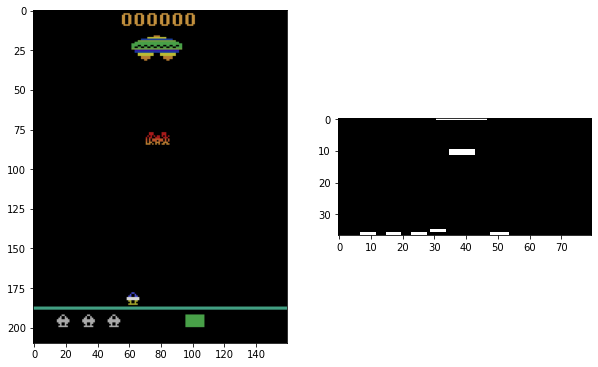

(37, 80)


In [5]:
frames_to_net = 1
frames_this_game = 0

env = gym.make("Assault-v0")

pix = env.reset()
for i in range(15):
    pix, reward, done, info = env.step(env.action_space.sample()) # take a random action
plot_environment(pix)
board_dimensions = segment_env(pix).shape

# pix = prepro(pix)
# dimensions = pix.shape


env.reset()
env.close()

print(board_dimensions)

In [6]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

## Random Play

In [7]:
# render = True
# slow = True
# score = 0
# frame_history = []
# action_history = []
# reward_history = []
# done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
# raw_pixels = env.reset()
# raw_pixels, reward, done, info = env.step(1)
# pixels = segment_env(raw_pixels)
# while not done:
#     action = np.random.choice(env.unwrapped.action_space.n-2) # we'll eventually pick the action from a NN
#     if render == True: # do you actually want to visualize the playing?
#         env.render()
#         if slow == True: # do you want to slow it down so you can see the game better?
#             time.sleep(0.01)
#     raw_pixels, reward, done, info = env.step(action)
#     frame_history.append(pixels)
#     action_history.append(action) # these are the action and reward when you saw the last frame
#     reward_history.append(reward)
#     pixels = segment_env(raw_pixels) # now this is the new frame
#     score += reward

# # after a game, with all that we saved we'll do a little optimization on the NN

### Policy Gradient with linear annealing, memory buffer, and same action for 4 consecutive frames

In [8]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [9]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [x for x in range(env.unwrapped.action_space.n)] # the possible actions we can take

# Training the NN

In [12]:
def create_model(height,width,channels, action_space):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(imp)
    mid = Conv2D(16,(5,5),strides=4,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(action_space,activation='softmax')(mid)
    model = Model(imp,out0, name= 'vanilla_shallow_CNN')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
    
    return model

# def create_model(height,width,channels, action_space):
#     # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
#     # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
#     # the effect is the same, just the way TF/keras handles weights is different
#     imp = Input(shape=(height,width,channels))
#     mid = Conv2D(32,(2,2),strides=4,activation='relu')(imp)
#     mid = MaxPool2D(pool_size = (2,2))(mid)
    
#     mid = Conv2D(64,(2,2),strides=2,activation='relu')(mid)
#     mid = MaxPool2D(pool_size = (2,2))(mid)
    
#     # mid = Conv2D(64,(2,2),strides=1,activation='relu')(mid)
#     # mid = MaxPool2D(pool_size = (2,2))(mid)
    
#     mid = Flatten()(mid)
    
#     mid = Dense(64,activation='relu')(mid)
#     mid = Dense(32,activation='relu')(mid)
#     out0 = Dense(action_space,activation='softmax')(mid)
#     model = Model(imp,out0, name='vanilla_deep_CNN')
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
    
#     return model

In [13]:
mod = create_model(
                height = board_dimensions[0],
                width = board_dimensions[1],
                channels = frames_to_net, 
                action_space = env.unwrapped.action_space.n - 2 # the -2 is because we don't want to fire left or right
            )
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "vanilla_shallow_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 39, 32)        2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 9, 16)          12816     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 163,893
Trainable params: 163,893

## Play the game

In [220]:
def play1game(model, ep, render=False, slow= 0.01):
    env0 = gym.make("Assault-v0")
    pix = env0.reset()
    pix = segment_env(pix)
    dimensions = pix.shape

    action_space = env0.unwrapped.action_space.n -2 # the -2 is because we don't want to fire left or right
    possible_actions = np.array([i for i in range(action_space)])
    
    frames_this_game = 0
    feed = np.zeros((1, dimensions[0], dimensions[1],frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    done = False
    fcount = 0
    while not done:
        if render == True: # do you actually want to visualize the playing?
           env0.render()
           time.sleep(slow)
           
        # skipping every 4 frames
        if fcount == 0:
            vf = model(feed,training=False).numpy()[0]
            # epsilon-greedy
            if np.random.random() < ep:
                action = np.random.choice(action_space)
            else:
                action = np.random.choice(possible_actions,p=vf)
            fcount += 1
        elif fcount == 3:
            fcount = 0
        else:
            fcount += 1

        action0 = possible_actions[action]
        pix_new, reward, done, info = env0.step(action0)
        frame_array.append(pix)
        action_array.append(action)
        reward_array.append(reward)
        pix = segment_env(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
    
    env.reset()
    env.close()
    return frame_array, action_array, reward_array, score

In [12]:
tgames = 10000 # training games
epsvec = np.linspace(1,0.05,tgames)
tgames = 7 # training games
# tgames = 50000
ngames = 200 # games played after training
nbatch = 10
buffn = 200000
warmupgames = 5
len_buff = 0
buffer = {'frames':[],'actions':[],'rewards':[]}

In [17]:
game = 0
scores = []
model_name = 'assault_v2'

pbar = tqdm(total=tgames)

with open(f'scores_{model_name}.csv','w') as out_file:
    out_file.write('game,score, train_time, len_buff\n')

    while True:
        pbar.update(1)
        start = time.time()
        g = min(game, tgames-1)
        frames, actions, rewards, score = play1game(mod, epsvec[g])
        rewards = discount_rewards(rewards.copy())
        # memory buffer
        buffer['frames'] += frames.copy()
        buffer['actions'] += actions.copy()
        buffer['rewards'] += rewards.copy()
        len_buff += len(actions)
        if len_buff > buffn:
            excess = len_buff - buffn
            buffer['frames'] = buffer['frames'][excess:].copy()
            buffer['actions'] = buffer['actions'][excess:].copy()
            buffer['rewards'] = buffer['rewards'][excess:].copy()
            len_buff = len(buffer['actions'])
        rewards = np.array(rewards)
        actions = np.array(actions)
        nframes = len(frames)
        current_frames = np.zeros((nframes, board_dimensions[0], board_dimensions[1],frames_to_net))
        
        if game >= warmupgames:
            prob = np.ones(len_buff)
            prob[np.array(buffer['rewards']) > 0] = 5.0
            prob /= np.sum(prob)
            which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
        
            for grab in range(nframes):
                rewards[grab] = buffer['rewards'][which_choose[grab]]
                actions[grab] = buffer['actions'][which_choose[grab]]
                for f in range(frames_to_net):
                    if grab-f > 0:
                        current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()
        
            history = mod.fit(current_frames,actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
        stop = time.time()
        
        game += 1
        # too many games to train on, hard stop
        if game >= tgames:
            break
        # append consecutive positive scores
        if score > 0:
            scores.append(score)
        elif len(scores) > 0:
            scores.pop(0)
        else:
            pass
        # stop training when NN has won 200 consecutive games
        if len(scores) > ngames:
            break
        # print(game, score, stop-start,len_buff)
        out_file.write(str(game)+','+str(score)+','+str(round(stop-start, 4))+','+str(len_buff)+'\n')
        out_file.flush()


        if (game + 1) % 50 == 0:
            mod.save(f'{model_name}.tf')

mod.save(f'{model_name}.tf')

 29%|██▊       | 2/7 [00:20<00:50, 10.08s/it]


INFO:tensorflow:Assets written to: assault_v2.tf/assets


In [ ]:
# mod.save(f'{model_name}.tf')

# Visualise the game after training

In [225]:
model_name = 'assault_v2_background_e10000'
mod2 = tf.keras.models.load_model(f'{model_name}.tf')
mod2.call = tf.function(mod2.call,experimental_relax_shapes=True)

mod2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 39, 32)        2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 9, 16)          12816     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 163,893
Trainable params: 163,893
Non-trainable

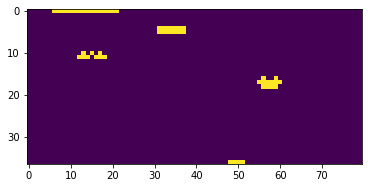

In [227]:
frame_array, action_array, reward_array, score = play1game(mod2, 0, render=True, slow=0.02)

plt.imshow(frame_array[-1])

In [230]:
ngames = 1000
scores = np.zeros(ngames)
for game in tqdm(range(ngames)):
    frames, actions, rewards, score = play1game(mod2, 0)
    scores[game] = score

np.mean(scores)

100%|██████████| 1000/1000 [55:10<00:00,  3.31s/it] 


523.614

(array([  9.,  35.,  52.,  56., 125.,  98., 111., 142., 325.,  47.]),
 array([126. , 186.9, 247.8, 308.7, 369.6, 430.5, 491.4, 552.3, 613.2,
        674.1, 735. ]),
 <BarContainer object of 10 artists>)

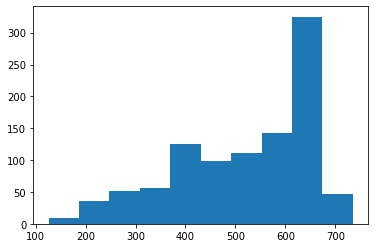

In [231]:
plt.hist(scores)